In [3]:
# -------------------------------
#Importing Dependencies
# -------------------------------
import csv
import os
# Organisation Libraries 
import pandas as pd
import numpy as np

# SQL Libraries
from sqlalchemy import create_engine
import psycopg2
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

import time
from getpass import getpass

# ML Libraryies
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import hvplot.pandas
import plotly.express as px

# Connecting to DB

In [4]:
# Using psycopg2 to pull from the NBA_Analysis DB
password = getpass()
cn = psycopg2.connect(host = "127.0.0.1", port = "5432", database = "NBA_Analysis", user = "postgres", password = password)
cur = cn.cursor()


#Querying test Data
cur.execute("""
SELECT main.id, main.player, main.u_player, misc.stl, misc.drb, misc.blk
FROM main  
LEFT JOIN misc
ON main.id = misc.id;
""")
test_results = cur.fetchall()

# Getting the column headers for test Table
cur.execute("""
SELECT main.id, main.player, main.u_player, misc.stl, misc.drb, misc.blk
FROM main  
LEFT JOIN misc
ON main.id = misc.id LIMIT 0;
""")
test_colnames = [desc[0] for desc in cur.description]

#NEW DATA ------------------------------------------s
# Over all player query
cur.execute("""
SELECT main.id, main.player, main.u_player, misc.vorp, misc.per, misc.bpm
FROM main  
LEFT JOIN misc
ON main.id = misc.id;
""")
ovr_results = cur.fetchall()

# Getting the column headers for test Table
cur.execute("""
SELECT main.id, main.player, main.u_player, misc.vorp, misc.per, misc.bpm
FROM main  
LEFT JOIN misc
ON main.id = misc.id LIMIT 0;
""")
ovr_colnames = [desc[0] for desc in cur.description]

#PCA Query ------------------------------------------
# Over all player query
cur.execute("""
SELECT t1.*, t2.ft, t2.fta, t2.ft_perc, t2.orb,
t2.drb, t2.trb, t2.ast, t2.stl, t2.blk, t2.tov, t2.pf,
t2.pts, t2.per, t2.bpm, t2.vorp
FROM main as t1 
LEFT JOIN misc as t2
ON t1.id = t2.id;
""")
pca_results = cur.fetchall()

# Getting the column headers for test Table
cur.execute("""
SELECT t1.*, t2.ft, t2.fta, t2.ft_perc, t2.orb,
t2.drb, t2.trb, t2.ast, t2.stl, t2.blk, t2.tov, t2.pf,
t2.pts, t2.per, t2.bpm, t2.vorp
FROM main as t1 
LEFT JOIN misc as t2
ON t1.id = t2.id LIMIT 0;
""")
pca_colnames = [desc[0] for desc in cur.description]


# Creating DataFrames

In [11]:
# Assigning SQL data to df's
test_df = pd.DataFrame(test_results)
test_df.columns = test_colnames
test_df.head()

#overall df
ovr_df = pd.DataFrame(ovr_results)
ovr_df.columns = ovr_colnames
ovr_df.head()

#overall df
pca_df = pd.DataFrame(pca_results)
pca_df.columns = pca_colnames
ovr_df.head()

,id,player,u_player,vorp,per,bpm
0,1,Álex Abrines,Álex Abrines 2016-17,0.1,10.1,-1.6
1,2,Quincy Acy,Quincy Acy 2016-17,0.0,11.8,-2.1
2,3,Steven Adams,Steven Adams 2016-17,1.1,16.5,-0.2
3,4,Arron Afflalo,Arron Afflalo 2016-17,-0.7,8.9,-3.6
4,5,Alexis Ajinça,Alexis Ajinça 2016-17,-0.2,12.9,-3.3


In [14]:
# Creating test
stl = test_df.groupby("player").mean()['stl']
drb = test_df.groupby("player").mean()['drb']
blk = test_df.groupby("player").mean()['blk']


#grouping players across seasons
grouped_test_df = pd.DataFrame({
    "steals": stl,
    "def_reb": drb,
    "blocks": blk
})

#creating ovr_ml_df
vorp = ovr_df.groupby("player").mean()['vorp']
per = ovr_df.groupby("player").mean()['per']
bpm = ovr_df.groupby("player").mean()['bpm']


#grouping players across seasons
ovr_ml_df = pd.DataFrame({
    "vorp": vorp,
    "per": per,
    "bpm": bpm
})

#creating pca df
g = pca_df.groupby("player").mean()['g']
gs = pca_df.groupby("player").mean()['gs']
mp = pca_df.groupby("player").mean()['mp']
fg = pca_df.groupby("player").mean()['fg']
fga = pca_df.groupby("player").mean()['fga']
fg_perc = pca_df.groupby("player").mean()['fg_perc']
threepoint = pca_df.groupby("player").mean()['threepoint']
threepoint_att = pca_df.groupby("player").mean()['threepoint_att']
threepoint_perc = pca_df.groupby("player").mean()['threepoint_perc']
twopoint = pca_df.groupby("player").mean()['twopoint']
twopoint_att = pca_df.groupby("player").mean()['twopoint_att']
twopoint_perc = pca_df.groupby("player").mean()['twopoint_perc']
efg_perc = pca_df.groupby("player").mean()['efg_perc']
ft = pca_df.groupby("player").mean()['ft']
fta = pca_df.groupby("player").mean()['fta']
ft_perc = pca_df.groupby("player").mean()['ft_perc']
orb = pca_df.groupby("player").mean()['orb']
drb = pca_df.groupby("player").mean()['drb']
trb = pca_df.groupby("player").mean()['trb']
ast = pca_df.groupby("player").mean()['ast']
stl = pca_df.groupby("player").mean()['stl']
blk = pca_df.groupby("player").mean()['blk']
tov = pca_df.groupby("player").mean()['tov']
pf = pca_df.groupby("player").mean()['pf']
pts = pca_df.groupby("player").mean()['pts']
per = pca_df.groupby("player").mean()['per']
bpm = pca_df.groupby("player").mean()['bpm']
vorp = pca_df.groupby("player").mean()['vorp']


#grouping players across seasons
pca_df = pd.DataFrame({
    "g": g,
    "gs": gs,
    "mp": mp,
    "fg": fg,
    "fga": fga,
    "fg_perc": fg_perc,
    "threepoint": threepoint,
    "threepoint_att": threepoint_att,
    "threepoint_perc": threepoint_perc,
    "twopoint": twopoint,
    "twopoint_att": twopoint_att,
    "twopoint_perc": twopoint_perc,
    "efg_perc": efg_perc,
    "ft": ft,
    "fta": fta,
    "ft_perc": ft_perc,
    "orb": orb,
    "drb": drb,
    "trb": trb,
    "ast": ast,
    "stl": stl,
    "blk": blk,
    "tov": tov,
    "pf": pf,
    "pts": pts,
    "per": per,
    "bpm": bpm,
    "vorp": vorp
})



#it looks like we have 69 duplictes, i looked through the list here and 
# it seems liek they are all scrubs. I vote for dropping the duplicates.
dict(grouped_test_df.duplicated().sort_values(ascending = False).head(69))
dict(ovr_ml_df.duplicated().sort_values(ascending = False).head(69))

cleaned_test_df = grouped_test_df.drop_duplicates()
cleaned_ovr_df = ovr_ml_df.drop_duplicates()

plotly_ovr_df = ovr_df.drop(["u_player","player"], axis =1)
pca_df.head()

,g,gs,mp,fg,fga,fg_perc,threepoint,threepoint_att,threepoint_perc,twopoint,...,trb,ast,stl,blk,tov,pf,pts,per,bpm,vorp
player,,,,,,,,,,,,,,,,,,,,,
A.J. Hammons,22.000000,0.000000,7.40,0.800000,1.900000,0.405000,0.200000,0.500000,0.5000,0.500000,...,1.600000,0.200000,0.000000,0.600000,0.500000,1.000000,2.200000,8.40,-6.600000e+00,-0.200000
Aaron Brooks,48.500000,0.500000,9.85,1.400000,3.400000,0.404500,0.500000,1.500000,0.3650,0.800000,...,0.800000,1.250000,0.300000,0.050000,0.650000,1.150000,3.650000,9.65,-3.750000e+00,-0.250000
Aaron Gordon,65.600000,63.800000,31.12,5.480000,12.300000,0.447400,1.400000,4.180000,0.3232,4.120000,...,6.760000,2.960000,0.800000,0.660000,1.700000,2.020000,14.620000,15.14,-1.665335e-17,1.020000
Aaron Harrison,7.000000,1.500000,14.65,1.050000,4.250000,0.137500,0.500000,2.600000,0.1045,0.550000,...,1.650000,0.900000,0.500000,0.100000,0.150000,1.700000,3.450000,1.45,-9.650000e+00,-0.150000
Aaron Holiday,60.666667,13.666667,18.40,2.733333,6.766667,0.401667,1.066667,2.866667,0.3670,1.666667,...,1.666667,2.333333,0.633333,0.233333,1.033333,1.533333,7.533333,10.90,-2.466667e+00,-0.133333


In [15]:
# Overall player K means
inertia = []
k = list(range(1, 11))
for i in k:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(plotly_ovr_df)
    inertia.append(km.inertia_)

elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)
df_elbow.hvplot.line(x="k", y="inertia", title="Elbow Curve", xticks=k)

:Curve   [k]   (inertia)

In [16]:
# PCA Elbow Curve
pca = PCA(n_components=5)

# Get two principal components for the iris data.
pca = pca.fit_transform(pca_df)
fin_pca_df = pd.DataFrame(
    data = pca, columns=["pc1","pc2","pc3","pc4","pc5"]
)
fin_pca_df

inertia = []
k = list(range(1, 11))
for i in k:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(fin_pca_df)
    inertia.append(km.inertia_)
    
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)
df_elbow.hvplot.line(x="k", y="inertia", title="Elbow Curve", xticks=k)

:Curve   [k]   (inertia)

# MACHINE LEARNING MODELING

In [17]:
# OVR MODEL
def get_clusters(k, data):
    # Create a copy of the DataFrame
    data = data.copy()

    # Initialize the K-Means model
    model = KMeans(n_clusters=k, random_state=0)

    # Fit the model
    model.fit(data)

    # Predict clusters
    predictions = model.predict(data)

    # Create return DataFrame with predicted clusters
    data["class"] = model.labels_

    return data

In [18]:
ovr_three_df = get_clusters(3, cleaned_ovr_df)
ovr_three_df

,vorp,per,bpm,class
player,,,,
A.J. Hammons,-0.200000,8.400000,-6.600000e+00,2
Aaron Brooks,-0.250000,9.650000,-3.750000e+00,2
Aaron Gordon,1.020000,15.140000,-1.665335e-17,1
Aaron Harrison,-0.150000,1.450000,-9.650000e+00,0
Aaron Holiday,-0.133333,10.900000,-2.466667e+00,2
...,...,...,...,...
Zion Williamson,2.350000,25.600000,3.950000e+00,1
Zylan Cheatham,-0.100000,6.700000,-7.200000e+00,2
Álex Abrines,0.000000,8.466667,-2.133333e+00,2


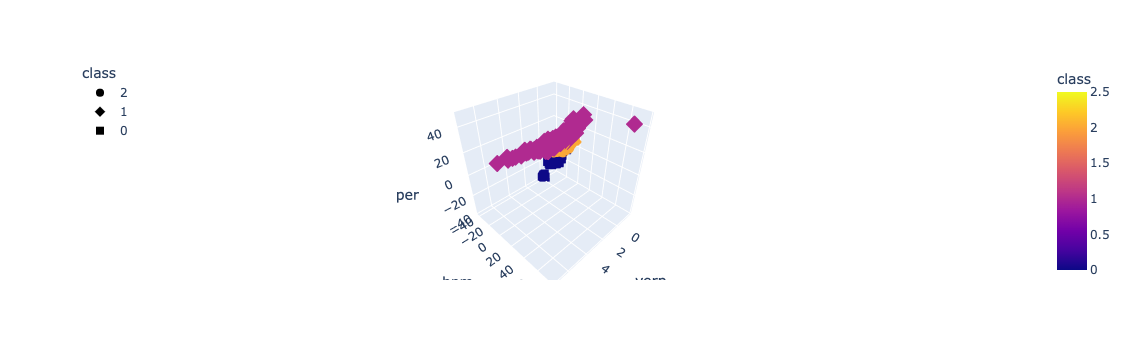

In [56]:
# Plotting OVR Model
fig = px.scatter_3d(
    ovr_three_df,
    x="vorp",
    y="bpm",
    z="per",
    color="class",
    symbol="class",
    width=800,
)
fig.update_layout(legend=dict(x=0, y=1))
fig.show()

In [42]:
# PCA MODEL
pca_three = get_clusters(3, fin_pca_df)
pca_three

,pc1,pc2,pc3,pc4,pc5,class
0,-26.213056,0.955034,-1.947688,-2.440955,-1.862444,1
1,-5.879285,18.456570,-1.851932,-2.132803,-1.085378,0
2,55.289997,-18.729965,-3.985933,-3.219697,0.267538,2
3,-34.386766,-11.841242,-6.869816,5.939548,2.865888,1
4,14.514033,15.782019,-2.251705,1.160349,0.379899,0
...,...,...,...,...,...,...
953,30.249834,-23.046787,15.353000,11.648018,-8.746702,2
954,-37.386387,-12.497156,-1.082400,3.259305,1.120634,1
955,5.909492,20.677845,-3.027276,0.773901,2.841101,0
956,-41.100651,-13.056838,-6.045166,0.603638,-2.748725,1


In [43]:
# Plotting OVR Model
fig = px.scatter_3d(
    pca_three,
    x="pc1",
    y="pc2",
    z="pc3",
    color="class",
    symbol="class",
    hover_name = pca_three.index,
    width=800,
)
fig.update_layout(legend=dict(x=0, y=1))
fig.show()

In [52]:
# Now, we are going a layer deeper.
# Specifically, we are looking at 'class 1' resulting from kmeans.
c_one_ovr = ovr_three_df[(ovr_three_df['class'] == 2) | (ovr_three_df['class'] == 3)]
inertia = []
k = list(range(1, 11))
for i in k:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(c_one_ovr)
    inertia.append(km.inertia_)

elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)
df_elbow.hvplot.line(x="k", y="inertia", title="Elbow Curve", xticks=k)

# Very interesting elbow curve here a layer deeper. 

:Curve   [k]   (inertia)

In [51]:
c_one_plot = get_clusters(3, c_one_ovr)

# Plotting Class 1
fig = px.scatter_3d(
    c_one_plot,
    x="vorp",
    y="bpm",
    z="per",
    color="class",
    symbol="class",
    hover_name = c_one_plot.index,
    width=800,
)
fig.update_layout(hovermode='x unified')

fig.show()

In [49]:
c_one_plot.head()

,vorp,per,bpm,class
player,,,,
A.J. Hammons,-0.200000,8.40,-6.600000,2
Aaron Brooks,-0.250000,9.65,-3.750000,0
Aaron Harrison,-0.150000,1.45,-9.650000,2
Aaron Holiday,-0.133333,10.90,-2.466667,0
Aaron Jackson,-0.100000,2.40,-8.900000,2
